In [56]:
import pandas as pd
import networkx as nx
import localization
import separation
import proximity
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np

In [57]:
dga = pd.read_csv("datasets/disease_gene.tsv", sep='\t')

dga = dga[dga.diseaseType == 'disease'][['geneSymbol', 'diseaseName']].drop_duplicates()

dga['diseaseName'] = dga['diseaseName'].str.lower()

num_genes = (dga.groupby('diseaseName')
             .agg('count')
             .sort_values(by='geneSymbol')
             .reset_index()
             .rename(columns={'geneSymbol':'count_genes'}))

filtered_dga = dga.merge(num_genes, 
                         on='diseaseName', 
                         how='inner')

cleaned_dga = filtered_dga[filtered_dga.count_genes>10][['geneSymbol', 'diseaseName']].drop_duplicates().reset_index(drop=True)

## 2.1 Disease module
Disease module. From the disease genes, localize the disease module in the
interactome. What is the size of the disease module? How is this module
significant when compared to a random module? Provide a visualization of the
disease module significance. Plot the subgraph formed by the disease module.

In [58]:
ppi = pd.read_csv('datasets/ppi.csv')
# drop duplicates
ppi = (ppi[['Symbol_A','Symbol_B']]
       .drop_duplicates()
       .dropna())
ppi.head()

,Symbol_A,Symbol_B
0,PHYHIP,KIF15
1,GPANK1,PNMA1
2,ZRSR2,TTC33
3,NRF1,MAN1B1
4,PI4KA,RGS20


In [59]:
gppi = nx.from_pandas_edgelist(ppi, 'Symbol_A', 'Symbol_B')

# Removing self loops
sl = nx.selfloop_edges(gppi)
gppi.remove_edges_from(sl)
print(f"Number of edges in the PPI after removing self loops: {len(gppi.edges)}")

Number of edges in the PPI after removing self loops: 322289


In [60]:
def get_disease_module_info(dis_name, gda, ppi):
    
    d = gda[gda.diseaseName == dis_name]
    genes = set(d.geneSymbol)
    genes_in_ppi = [n for n in gppi.nodes if n in genes]
    genes_in_lcc = localization.get_lcc(ppi, genes_in_ppi)
    
    disease_module = ppi.subgraph(genes_in_lcc)

    return genes, genes_in_ppi, genes_in_lcc, disease_module

In [61]:
# Get the disease module for 'dermatitis'
dermatitis_genes, dermatitis_in_ppi, dermatitis_in_lcc, dermatitis_module = get_disease_module_info('dermatitis', cleaned_dga, gppi)

# Calculate the size of the disease module
disease_module_size = len(dermatitis_module.nodes)

print(f"The size of the disease module for 'dermatitis' is: {disease_module_size}")

The size of the disease module for 'dermatitis' is: 7


In [152]:
# Get the disease module for 'schizophrenia'
np.random.seed(1234)
random_dis_name = np.random.choice(cleaned_dga.diseaseName.unique())
print(f"Random disease name: {random_dis_name}")

random_genes, random_in_ppi, random_in_lcc, random_module = get_disease_module_info(random_dis_name, cleaned_dga, gppi)


# Calculate network properties for the disease module
disease_properties = [
    dermatitis_module.number_of_nodes(),
    dermatitis_module.number_of_edges(),
    sum(dict(dermatitis_module.degree()).values()) / dermatitis_module.number_of_nodes(),
    nx.density(dermatitis_module),
    nx.average_clustering(dermatitis_module)
]

# Calculate network properties for the random module
random_properties = [
    random_module.number_of_nodes(),
    random_module.number_of_edges(),
    sum(dict(random_module.degree()).values()) / random_module.number_of_nodes(),
    nx.density(random_module),
    nx.average_clustering(random_module)
]
metrics = ["# Nodes", "# Edges", "Average Degree", "Density", "Clustering Coefficient"]

# Create a DataFrame from the dictionaries

df = pd.DataFrame({'Disease Module': disease_properties, 'Random Module': random_properties}, index=metrics)
df

Random disease name: akinetic-rigid variant of huntington disease


,Disease Module,Random Module
# Nodes,7.000000,2.0
# Edges,6.000000,1.0
Average Degree,1.714286,1.0
Density,0.285714,1.0
Clustering Coefficient,0.000000,0.0


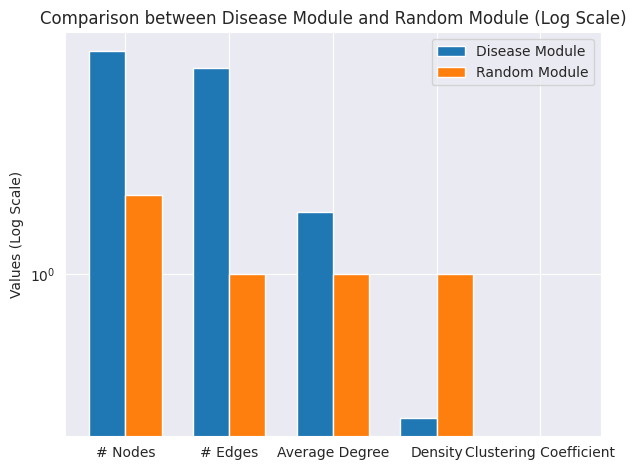

In [148]:
x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, disease_properties, width, label='Disease Module')
rects2 = ax.bar(x + width/2, random_properties, width, label='Random Module')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Values (Log Scale)')
ax.set_yscale('log')  # Set the scale of the y-axis to logarithmic
ax.set_title('Comparison between Disease Module and Random Module (Log Scale)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Function to attach a text label above each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')



fig.tight_layout()

plt.show()

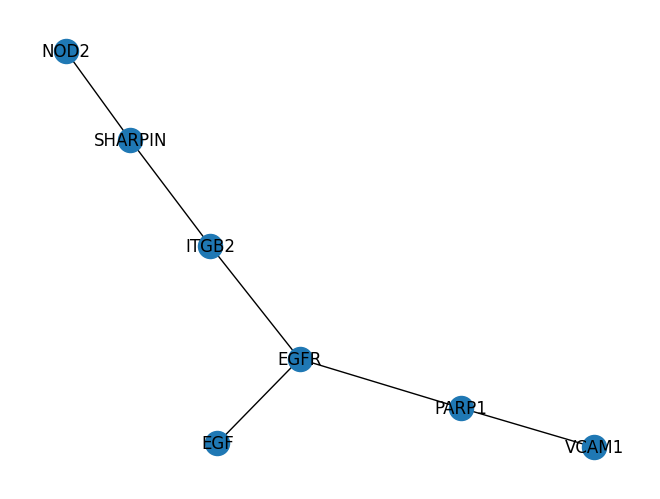

In [64]:
# Draw the disease module
nx.draw(dermatitis_module, with_labels=True)

# Display the plot
plt.show()

## 2.2 Disease separation
Work on the molecular overlap of the disease you are
studying with other diseases. Chose two particular diseases: one that apparently
might overlap with your disease and one that apparently might be very distant to
your disease. Compute the separation in the interactome of the two disease
modules. Connect this question to question 3.2. Discuss the possible
implications of the separation between the two diseases.

In [150]:
psoriasis_genes, psoriasis_in_ppi, psoriasis_in_lcc, psoriasis_module = get_disease_module_info('psoriasis', cleaned_dga, gppi)
separation_dermatitis_psoriasis = separation.get_separation(gppi, psoriasis_in_lcc, dermatitis_in_lcc)
print(f"separation_dermatitis_psoriasis : {separation_dermatitis_psoriasis}")

separation_dermatitis_psoriasis : 1.6216216216216217


In [66]:
# Get the disease module for 'schizophrenia'
schizophrenia_genes, schizophrenia_in_ppi, schizophrenia_in_lcc, schizophrenia_module = get_disease_module_info('schizophrenia', cleaned_dga, gppi)
seperation_dermatitis_schizophrenia = separation.get_separation(gppi, schizophrenia_in_lcc, dermatitis_in_lcc)
print(f"seperation_dermatitis_schizophrenia : {seperation_dermatitis_schizophrenia}")

seperation_dermatitis_schizophrenia : 1.8753623188405797


## 2.3. Disease - drug proximity
Apart from the drugs that are specifically indicated
for the disease you are studying, can you provide some new repurposing
opportunities? Look at some of the drugs whose targets are specifically in the
module of your disease and use the proximity metric to describe how near the
disease and the drug are.

In [67]:
drug_target_data = pd.read_csv('datasets/drug_target.csv')
drug_target_data = drug_target_data[drug_target_data.organism=='Humans'][['Gene_Target','Name']].drop_duplicates()

In [68]:
def plot_proximity(G, genes, targets, sim):
    
    prox_dict = proximity.get_proximity(G, genes, targets, sim)
    
    prox_obs = prox_dict['proximity']
    random_prox = prox_dict['proximity_list']

    print('Proximity observed: ',prox_obs)
    print('\nMean: ',prox_dict['mean'])
    print('Std: ',prox_dict['std'])
    print('z-score: ',prox_dict['z_score'])
    print('p-value: ',prox_dict['p_value'])


    fig, axs = plt.subplots()
    sns.histplot(data=random_prox,
                 bins=10)
    plt.axvline(prox_obs, color='r')
    plt.xlabel('Proximity value')
    plt.ylabel('Count iterations')
    plt.tight_layout()
    plt.show()

                                                    Name
1                                              Cetuximab
2140                                        Theophylline
2190                                           Lidocaine
2462                                           Gefitinib
2835                                          Sucralfate
4115                                           Erlotinib
6751                                             Ethanol
8576                                          Carvedilol
9567                                           Lapatinib
9629                                         Panitumumab
10634                                               Zinc
12291            Carba-nicotinamide-adenine-dinucleotide
12570                                             NU1025
12584                                       Nicotinamide
13138  2-{3-[4-(4-Fluorophenyl)-3,6-Dihydro-1(2h)-Pyr...
13139                                 3-Methoxybenzamide
13955                          

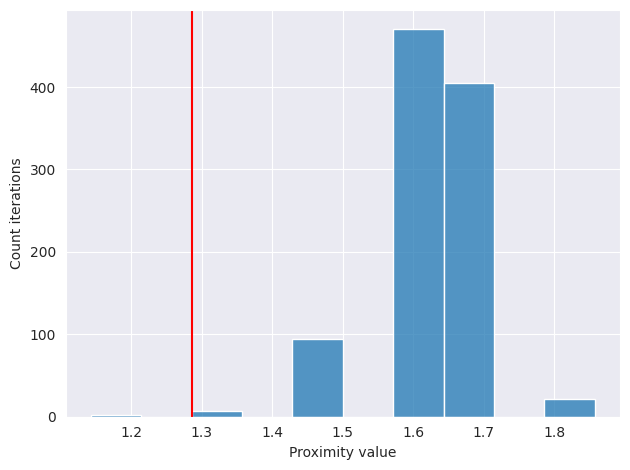

In [55]:
dermatitis_drugs = drug_target_data[drug_target_data.Gene_Target.isin(dermatitis_in_lcc)][['Name']].drop_duplicates()
print(dermatitis_drugs)
print(dermatitis_drugs.iloc[0]['Name'])

le_t = drug_target_data[drug_target_data.Name == dermatitis_drugs.iloc[0]['Name']].Gene_Target.unique()

print('\tTargets: ',le_t)

plot_proximity(gppi, 
               set(dermatitis_in_lcc), 
               set(le_t), 
               1000)

# 3. Disease networks


In [48]:
G = nx.Graph()

G.add_nodes_from(cleaned_dga.geneSymbol, bipartite=0)
G.add_nodes_from(cleaned_dga.diseaseName, bipartite=1)

G.add_edges_from(cleaned_dga.values)

In [49]:
g_projected = nx.algorithms.bipartite.projected_graph(G, nodes=cleaned_dga.diseaseName)

## 3.1. General network metrics
 From the disease-gene associations (bipartite graph,
two types of nodes: diseases and genes), generate the projected disease
network (one type of nodes: diseases). Give some basic information on the
complex networks’ metrics that we have studied in class. You should describe
at least the following points:
‒ Diameter of the network
‒ Number of connected components in the network
‒ Size of the largest connected component in the network
‒ Plot of the degree distribution
‒ Identification of some hubs (name the diseases)
‒ Plot of the shortest path length distribution

In [80]:
# Diameter of the network
diameter = nx.diameter(g_projected)
print(f"The diameter of the network is: {diameter}")

NetworkXError: Found infinite path length because the graph is not connected

In [82]:
# Number of connected components in the network
num_connected_components = nx.number_connected_components(g_projected)
print(f"The number of connected components in the network is: {num_connected_components}")

The number of connected components in the network is: 2


In [86]:
# Size of the largest connected component in the network
largest_connected_component = max(nx.connected_components(g_projected), key=len)
smallest_connected_components = min(nx.connected_components(g_projected), key=len)
print(f"The size of the largest connected component in the network is: {len(largest_connected_component)}")
print(f"The size of the smallest connected component in the network is: {len(smallest_connected_components)}")
print(smallest_connected_components)

The size of the largest connected component in the network is: 919
The size of the smallest connected component in the network is: 1
{'spermatogenic failure, nonobstructive, y-linked'}


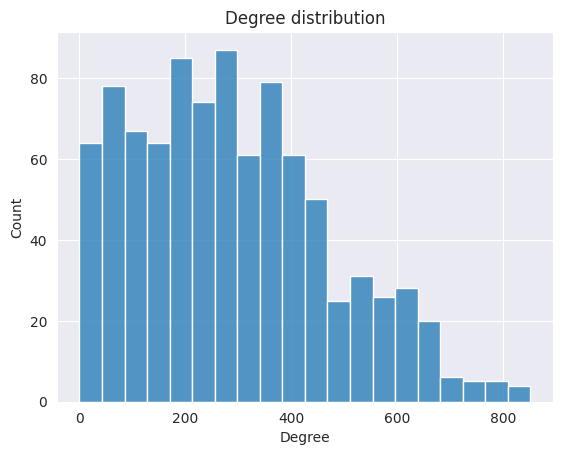

In [88]:
# Plot of the degree distribution
degrees = [g_projected.degree(n) for n in g_projected.nodes()]
sns.histplot(degrees, bins=20)
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree distribution')
plt.show()

In [89]:
# Identification of some hubs (name the diseases)
degree_dict = dict(g_projected.degree(g_projected.nodes()))
sorted_degree = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)
print("Top 10 diseases by degree:")
for d in sorted_degree[:10]:
    print(d)

Top 10 diseases by degree:
('malignant neoplasm of breast', 852)
('schizophrenia', 822)
('malignant neoplasm of prostate', 818)
('colorectal carcinoma', 816)
('breast carcinoma', 807)
('mammary neoplasms, human', 800)
('mammary carcinoma, human', 800)
('liver carcinoma', 770)
('bipolar disorder', 769)
('malignant neoplasm of lung', 754)


In [141]:
# Plot of the shortest path length distribution
shortest_path_lengths = nx.all_pairs_shortest_path_length(g_projected)

In [142]:
# Flatten the dictionary of dictionaries into a list of shortest path lengths
shortest_path_lengths_flattened = [length for source in shortest_path_lengths for length in source[1].values()]

In [139]:
shortest_path_lengths_count = np.bincount(shortest_path_lengths_flattened)

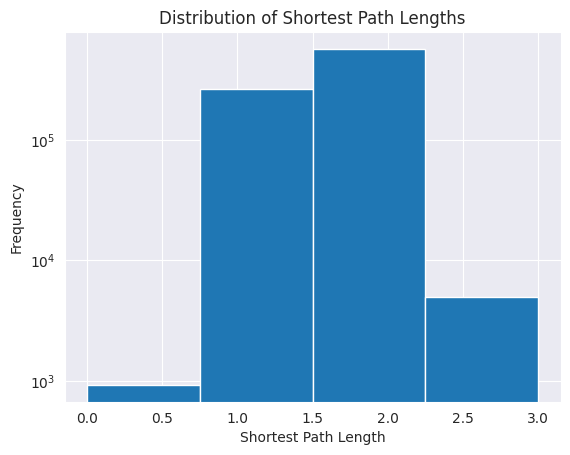

In [140]:
# Plot the distribution of shortest path lengths
plt.hist(shortest_path_lengths_flattened, bins=4)
plt.xlabel('Shortest Path Length')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Distribution of Shortest Path Lengths')
plt.show()

## 3.2 Specific disease in the network.
Study the position of your disease in the
projected network. What is the degree of your disease? Which diseases is your
disease connected to? (Give some examples if there are two many). Plot the
subgraph of your disease and those diseases that is connected to. What is the
average shortest path length of your disease to the other diseases in the
network? 

In [72]:
# degree of dermatitis
disease = "dermatitis"

dermatitis_degree = g_projected.degree[disease]
print(f"Degree of dermatitis: {dermatitis_degree}")

Degree of dermatitis: 203


In [77]:
neighbours_disease = list(g_projected.neighbors(disease))
print(f"Neighbours of dermatitis: {len(neighbours_disease)}")
neighbours_disease[:10]

Neighbours of dermatitis: 203


['schizophrenia',
 'malignant tumor of colon',
 'kidney failure, acute',
 'liver cirrhosis, experimental',
 'malignant neoplasm of lung',
 'acute kidney insufficiency',
 'liver carcinoma',
 'acute kidney injury',
 'alcoholic intoxication, chronic',
 'malignant neoplasm of urinary bladder']

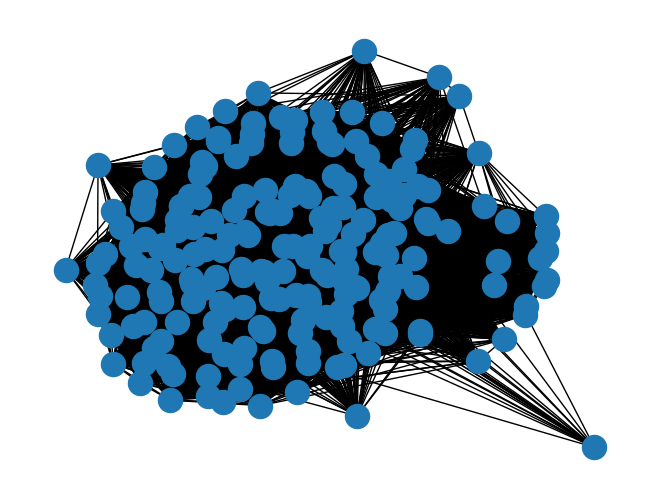

In [75]:
subgraph = g_projected.subgraph([disease] + neighbours_disease)
nx.draw(subgraph)
plt.show()

In [ ]:
# Calculate the shortest path length from 'dermatitis' to all other nodes
average_shortest_path_length = nx.average_shortest_path_length(g_projected, 'dermatitis')

print(f"The average shortest path length of 'dermatitis' to the other diseases in the network is: {average_shortest_path_length}")